## Lab 3

### Part 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.92 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и/или числа слоев и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

## Used libraries

In [1]:
import torchvision
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, nn, optim, exp
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm_notebook as tqdm

### Used constants

In [2]:
train_size = 0.8
images_mean = tensor([0.5])
images_std = tensor([0.5])
batch = 64
p = 0.2

descriptions = ("T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot",
                )

label_decoder = dict(zip(range(10), descriptions))

### Download the dataset and define a dataloader

In [3]:
dataset_train = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(images_mean, images_std)
    ])
)

dataset_test = datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(images_mean, images_std)
    ])
)

def define_loaders(dataset_train, dataset_test):
    len_data = len(dataset_train)
    length_train, length_val = int(len_data*train_size), int(len_data - len_data*train_size)
    train, val = random_split(dataset_train, [length_train, length_val])
    return DataLoader(train, batch_size=batch, shuffle=True, num_workers=2),\
           DataLoader(val, batch_size=length_val, num_workers=2),\
           DataLoader(dataset_test, batch_size=batch, shuffle=True, num_workers=2),\

train_loader, val_loader, test_loader = define_loaders(dataset_train, dataset_test)

### View images

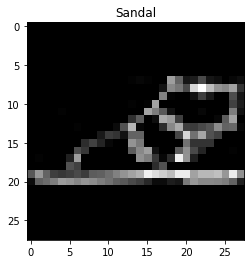

In [4]:
def imshow(img, label):
    img = img * images_std.item() + images_mean.item()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(label_decoder[label[0].item()])
    
images, label = next(iter(train_loader))
imshow(images[0, :], label)

### Train function

In [5]:
def train_network(net, criterion, epochs, l_rate, decay):
    train_loss = []
    val_loss = []
    optimizer = optim.Adam(net.parameters(), lr = l_rate, weight_decay = decay)
    
    for i in tqdm(range(epochs)):
        running_classification_loss = 0
        running_cycle_consistent_loss = 0
        running_loss = 0
        
        if i == 40:
            optimizer = optim.Adam(net.parameters(), lr = l_rate/20, weight_decay = decay/10)
            
        for images, labels in train_loader:
            net.train(True)
            optimizer.zero_grad()

            # Run classification model
            predicted_labels = net(images)
            classification_loss = criterion(Flatten()(predicted_labels), labels)

            # Optimize classification weights
            classification_loss.backward()
            optimizer.step()

            running_classification_loss += classification_loss.item()
            running_loss = running_classification_loss
        else:
            net.train(False)
            train_loss.append(running_loss/len(train_loader))
            images, labels = next(iter(val_loader))
            predicted_labels = net(images)
            val_loss.append(criterion(Flatten()(predicted_labels), labels).item()/len(val_loader))
            
    return train_loss, val_loss

### Evaluate function

In [6]:
def evaluate(net):
    total_correct = 0
    total_num = 0
    for images, labels in test_loader:
        net.train(False)
        ps = Flatten()(exp(net(images)))
        predictions = ps.topk(1, 1, True, True)[1].t()
        correct = predictions.eq(labels.view(1, -1))

        total_correct += correct.sum().cpu().numpy()
        total_num += images.shape[0]
        
    return total_correct / float(total_num)

### Define the networks

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

basic_net = nn.Sequential(
    nn.Conv2d(1, 4, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(4, 8, 3, stride=2),
    Flatten(),
    nn.Linear(8*6*6, 10),
    nn.LeakyReLU(),
    nn.LogSoftmax(dim=1)
)

updated_net = nn.Sequential(
    nn.Conv2d(1, 32, 4, stride=2),
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout(p),
    nn.Conv2d(32, 64, 3, stride=2),
    nn.LeakyReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 2, stride=2),
    Flatten(),
    nn.Linear(128*9, 512),
    nn.LeakyReLU(),
    nn.Dropout(p),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(p),
    nn.Linear(256, 100),
    nn.LeakyReLU(),
    nn.Dropout(p),
    nn.Linear(100, 10),
    nn.LeakyReLU(),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
epochs = 50

### Show results

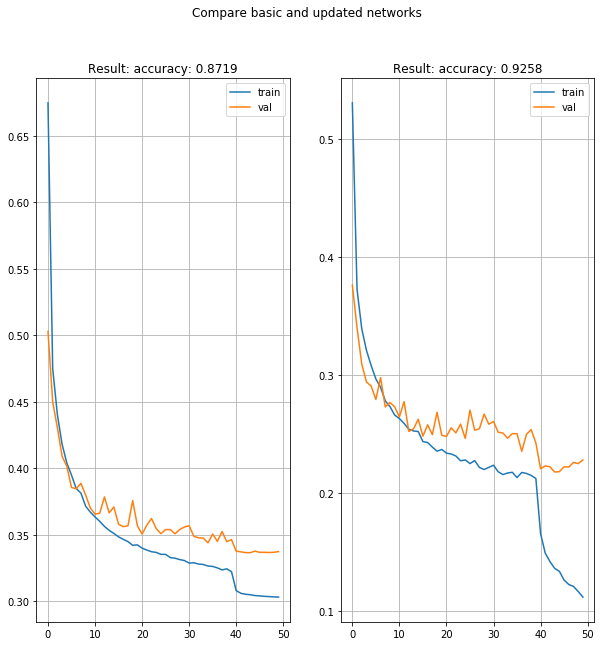

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
fig.suptitle('Compare basic and updated networks')
for i in range(2):
    net = basic_net if i == 0 else updated_net
    train, val = train_network(net, criterion, epochs, 1e-3, 1e-3)
    ax[i].plot(train, label='train')
    ax[i].plot(val, label='val')
    ax[i].set_title('Result: accuracy: ' + str(evaluate(net)))
    ax[i].legend()
    ax[i].grid()

plt.show()

### As u can see, i have achieved more than 92% quality using Batchnorm and dropout. I also made comparisons between a simple network and a network using regularizations and gave training schedules